In [18]:
# Import the necessary modules
import torch
import torchvision
# import torch.nn.functional as F
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import os

iter = 1

In [19]:
num_channels, img_size, img_size = 3, 512, 512
output_folder = f'output/synthesized{iter}'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
input = f'input/synthesized{iter}'
if not os.path.exists(input):
    os.makedirs(input)

In [20]:
import torch
import torchvision.transforms.functional as F

def gradient_blur(image, position, blur_size):
    # image: a torch tensor of shape [C, H, W]
    # position: a tuple of (x, y) coordinates
    # returns: a blurred image tensor of the same shape as input

    # get the image height and width
    height = image.shape[1]
    width = image.shape[2]


    # make sure the blur size is odd and at least 3
    blur_size = max(3, blur_size + (1 - blur_size % 2))

    # set the x range to cover the full width of the image
    y_min = 0
    y_max = width

    # get the y range for the blur region
    x_min = max(0, position - blur_size // 2)
    x_max = min(height, position + blur_size // 2 + 1)

    # crop the blur region from the image
    blur_region = image[:, x_min:x_max, y_min:y_max]

    # apply gaussian blur to the region
    blurred_region = F.gaussian_blur(blur_region, kernel_size=blur_size)

    # replace the original region with the blurred one
    image[:, x_min:x_max, y_min:y_max] = blurred_region

    # return the blurred image
    return image


In [21]:
# Define a function that takes an image and returns a stacked image
def stack_images(image, num_images):
    # Define the number of images and the image size
    img_size = image.size[0]

    # Convert the image to a tensor
    tensor = torchvision.transforms.ToTensor()(image)

    # Define the jitter and warp parameters
    jitter = 3 # The maximum amount of random shift in pixels
    warp = 0.005 # The maximum amount of random distortion in fraction of image size

    # Create a list of tensors and apply jitter and warp transformations
    tensors = []
    for i in range(num_images):
        # Randomly shift the tensor by a small amount
        dx = np.random.randint(-jitter, jitter + 1) # Random x shift
        dy = np.random.randint(-jitter, jitter + 1) # Random y shift
        shifted_tensor = torch.roll(tensor, shifts=(dx, dy), dims=(1, 2))

        # Randomly distort the tensor by a small amount
        dw = np.random.uniform(-warp, warp) * img_size # Random width distortion
        dh = np.random.uniform(-warp, warp) * img_size # Random height distortion
        distorted_tensor = torchvision.transforms.functional.affine(shifted_tensor, angle=0, translate=(0, 0), scale=1, shear=(dw, dh))

        # Append the distorted tensor to the list
        tensors.append(distorted_tensor)

    # # Stack the tensors along the horizontal axis
    # stacked_tensor = torch.cat(tensors, dim=2)

    # # Convert the stacked tensor to a PIL image
    # stacked_image = torchvision.transforms.ToPILImage()(stacked_tensor)

    # Return the stacked image
    return tensors


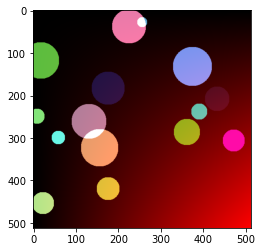

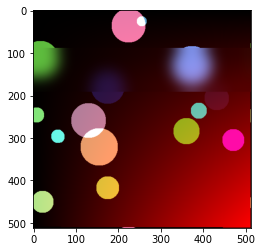

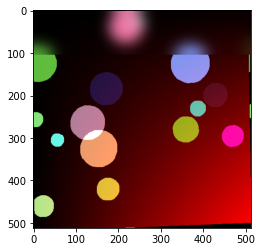

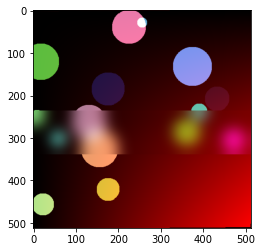

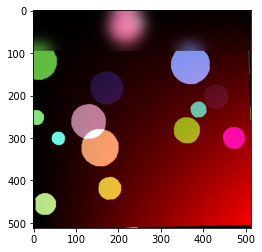

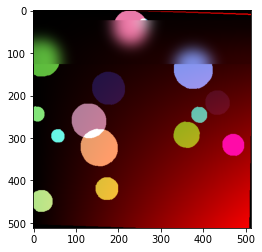

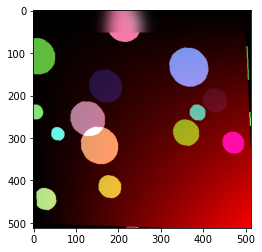

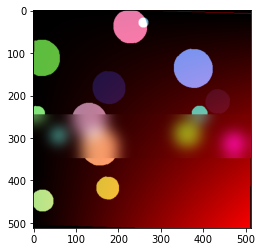

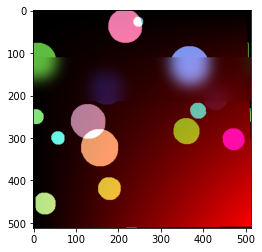

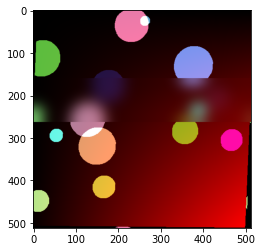

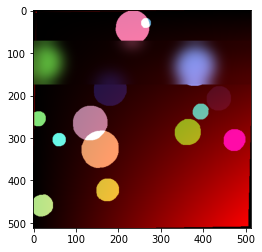

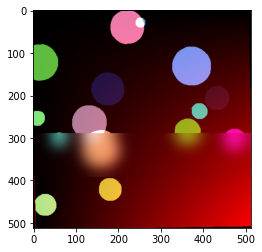

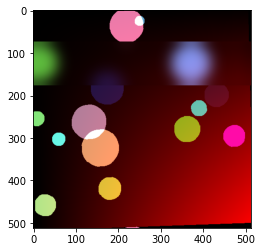

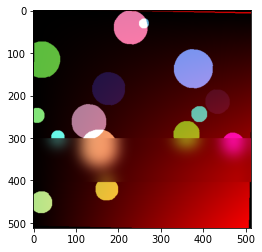

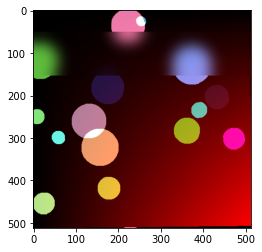

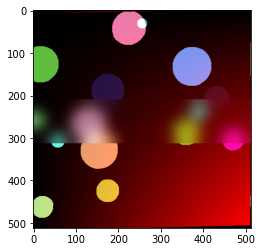

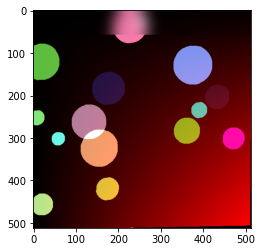

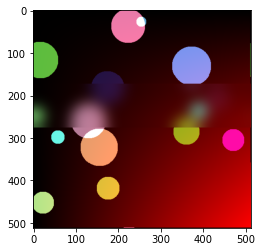

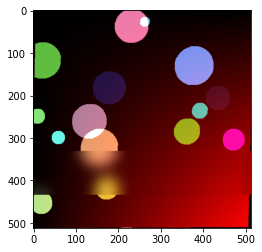

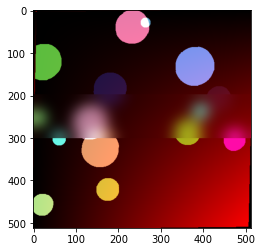

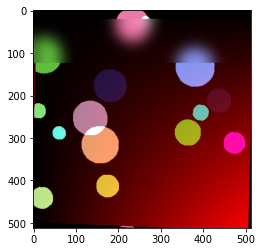

In [22]:
# Create an image using the previous code (without plotting)
img = torch.zeros(num_channels, img_size, img_size)
grad = torch.linspace(0, 1, img_size).view(1, -1).repeat(num_channels, img_size, 1) * torch.linspace(0, 1, img_size).view(-1, 1).repeat(num_channels, 1, img_size)
img[0] = grad[0]
num_circles = 15
for _ in range(num_circles):
    x = np.random.randint(0, img_size)
    y = np.random.randint(0, img_size)
    r = np.random.randint(10, 50)
    c = torch.rand(num_channels)
    mask = torch.zeros(num_channels, img_size, img_size)
    for i in range(img_size):
        for j in range(img_size):
            dist = ((i - x)**2 + (j - y)**2)**0.5
            if dist < r:
                mask[:, i, j] = 1
    img = img + c.view(-1, 1, 1) * mask
img = torch.clamp(img, 0, 1)
img = torchvision.transforms.ToPILImage()(img)

plt.imshow(img)
plt.imsave(f'input/synthesized{iter}gt.png', img, format="png")
plt.show()
# Call the stack_images function and plot the result
num_images = 20
results = stack_images(img, num_images)
blur_height = img_size//5
j = 0
for result in results:
    n = random.randint(0, img_size-blur_height-3)
    result = gradient_blur(result, n, blur_height)
    image_np = result.numpy()

    # Transpose the array to put the channels as the last dimension
    image_np = image_np.transpose(1, 2, 0) # or image_np = image_tensor.permute(1, 2, 0).numpy()
    

    # Plot the image using plt
    plt.imshow(image_np)
    plt.imsave(f'input/synthesized{iter}/step{j}.png', image_np, format="png")
    plt.show()
    j += 1


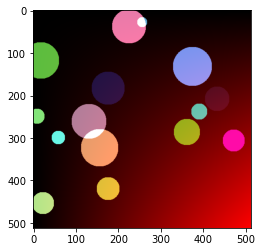

In [36]:
import numpy as np
import os
from PIL import Image

img.save(f"output/synthesized{iter}gt.png", "PNG")

plt.imshow(img)
# plt.imsave(f'input/synthesized{iter}gt.png', img, format="png")
plt.show()

In [1]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision.transforms import ToTensor

# create a criterion that measures MSE loss
criterion = nn.MSELoss()

# create some dummy input and target images
input1 = Image.open(f'output/synthesized{iter}/FAIS_result.png')
input2 = Image.open(f'output/synthesized{iter}/resize_beseline_result.png')
target = Image.open(f'output/synthesized{iter}/synthesized{iter}gt.png')

input1 = ToTensor()(input1)
input2 = ToTensor()(input2)
target = ToTensor()(target)

# print input and target types
input1, input2, target = input1.float(), input2.float(), target.float()
# compute the MSE loss
mse1 = criterion(input1, target)
psnr1 = 10 * np.log10(255**2 / mse1)
mse2 = criterion(input2, target)
psnr2 = 10 * np.log10(255**2 / mse2)
print("Lower is better (MSE)")
print("our method: ", mse1.item())
print("Base line: ", mse2.item())
print("Higher is better (PSNR)")
print("our method: ", psnr1.item())
print("Base line: ", psnr2.item())

FileNotFoundError: [Errno 2] No such file or directory: 'output/synthesized<built-in function iter>/FAIS_result.png'

In [11]:
## custom image paths

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import numpy as np

# create a criterion that measures MSE loss
criterion = nn.MSELoss()
## override iter
# iter = 1
# create some dummy input and target images
input1 = torchvision.io.read_image(f'output/synthesized{iter}/FAIS_result.png')
input2 = torchvision.io.read_image(f'output/Zerene_Stacker/Zerene_PMax.jpg')
target = torchvision.io.read_image(f'output/synthesized{iter}/synthesized{iter}gt.png')

# print input and target types
input1, input2, target = input1.float(), input2.float(), target.float()
# compute the MSE loss
mse1 = criterion(input1, target)
psnr1 = 10 * np.log10(255**2 / mse1)
mse2 = criterion(input2, target)
psnr2 = 10 * np.log10(255**2 / mse2)
print("Lower is better (MSE)")
print("our method: ", mse1.item())
print("software: ", mse2.item())
print("Higher is better (PSNR)")
print("our method: ", psnr1.item())
print("software: ", psnr2.item())

Lower is better (MSE)
our method:  597.814453125
software:  878.7437133789062
Higher is better (PSNR)
our method:  20.365140914916992
software:  18.692180633544922
